<a href="https://colab.research.google.com/github/nravinuthala/EVA4.0/blob/master/EVA4S6_L1_L2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Target
1. Use L1 & L2
2. Run for 40 epochs
3. Save model

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

In [0]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())
'''
print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')
'''

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


TypeError: ignored

## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 12

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 10

        

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 6

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 5
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(10),
           nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 5
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        ) # output_size = 1
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.gap(x)
        x = self.convblock9(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [6]:
!pip install torchsummary
from torchsummary import summary

In [7]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
       BatchNorm2d-6           [-1, 16, 24, 24]              32
              ReLU-7           [-1, 16, 24, 24]               0
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10           [-1, 10, 12, 12]             160
      BatchNorm2d-11           [-1, 10, 12, 12]              20
             ReLU-12           [-1, 10, 12, 12]               0
          Dropout-13           [-1, 10, 12, 12]               0
           Conv2d-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
l1_crit = nn.L1Loss(size_average=False)
reg_loss = 0
for param in model.parameters():
  #print(param.shape)
  if param.dim() > 1:
    #reg_loss += l1_crit(param.norm(1))
    reg_loss += param.norm(1)

factor = 0.0005
loss += factor * reg_loss

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  crit = nn.CrossEntropyLoss().to(device)
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    #loss = F.nll_loss(y_pred, target)
    #l1_crit = nn.L1Loss(size_average=False)
    reg_loss = 0
    for param in model.parameters():
      reg_loss += torch.sum(abs(param))
    
    classify_loss = crit(y_pred, target)

    factor = 0.0005
    loss = classify_loss + factor * reg_loss
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [10]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.1, weight_decay=0.01)
scheduler = StepLR(optimizer, step_size=4, gamma=0.1)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=2.5411629676818848 Batch_id=468 Accuracy=10.79: 100%|██████████| 469/469 [00:14<00:00, 32.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.2959, Accuracy: 1359/10000 (13.59%)

EPOCH: 1


Loss=2.4854042530059814 Batch_id=468 Accuracy=22.11: 100%|██████████| 469/469 [00:14<00:00, 31.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.2415, Accuracy: 1437/10000 (14.37%)

EPOCH: 2


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.1782, Accuracy: 2045/10000 (20.45%)

EPOCH: 3


Loss=2.333484172821045 Batch_id=468 Accuracy=32.45: 100%|██████████| 469/469 [00:14<00:00, 31.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.1063, Accuracy: 2632/10000 (26.32%)

EPOCH: 4


Loss=2.301381826400757 Batch_id=468 Accuracy=35.35: 100%|██████████| 469/469 [00:15<00:00, 30.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.0202, Accuracy: 3104/10000 (31.04%)

EPOCH: 5


Loss=2.152385711669922 Batch_id=468 Accuracy=36.64: 100%|██████████| 469/469 [00:14<00:00, 31.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.9418, Accuracy: 3201/10000 (32.01%)

EPOCH: 6


Loss=2.0517866611480713 Batch_id=468 Accuracy=37.62: 100%|██████████| 469/469 [00:14<00:00, 31.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.8530, Accuracy: 3336/10000 (33.36%)

EPOCH: 7


Loss=2.0018575191497803 Batch_id=468 Accuracy=38.63: 100%|██████████| 469/469 [00:15<00:00, 31.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.7676, Accuracy: 3538/10000 (35.38%)

EPOCH: 8


Loss=1.8191760778427124 Batch_id=468 Accuracy=40.49: 100%|██████████| 469/469 [00:14<00:00, 31.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.6837, Accuracy: 3926/10000 (39.26%)

EPOCH: 9


Loss=2.0102248191833496 Batch_id=468 Accuracy=43.28: 100%|██████████| 469/469 [00:15<00:00, 31.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.6129, Accuracy: 4300/10000 (43.00%)

EPOCH: 10


Loss=1.8424739837646484 Batch_id=468 Accuracy=47.20: 100%|██████████| 469/469 [00:15<00:00, 31.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.5350, Accuracy: 4883/10000 (48.83%)

EPOCH: 11


Loss=1.6772122383117676 Batch_id=468 Accuracy=51.92: 100%|██████████| 469/469 [00:14<00:00, 31.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.4546, Accuracy: 5520/10000 (55.20%)

EPOCH: 12


Loss=1.5865552425384521 Batch_id=468 Accuracy=56.98: 100%|██████████| 469/469 [00:15<00:00, 30.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.3733, Accuracy: 6062/10000 (60.62%)

EPOCH: 13


Loss=1.6002297401428223 Batch_id=468 Accuracy=61.86: 100%|██████████| 469/469 [00:14<00:00, 31.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.2896, Accuracy: 6632/10000 (66.32%)

EPOCH: 14


Loss=1.5231616497039795 Batch_id=468 Accuracy=66.38: 100%|██████████| 469/469 [00:15<00:00, 30.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.2053, Accuracy: 6934/10000 (69.34%)

EPOCH: 15


Loss=1.4634301662445068 Batch_id=468 Accuracy=69.33: 100%|██████████| 469/469 [00:14<00:00, 32.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.1349, Accuracy: 7196/10000 (71.96%)

EPOCH: 16


Loss=1.3727108240127563 Batch_id=468 Accuracy=71.66: 100%|██████████| 469/469 [00:14<00:00, 31.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.0581, Accuracy: 7412/10000 (74.12%)

EPOCH: 17


Loss=1.2280890941619873 Batch_id=468 Accuracy=73.79: 100%|██████████| 469/469 [00:14<00:00, 32.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.9825, Accuracy: 7610/10000 (76.10%)

EPOCH: 18


Loss=1.2149670124053955 Batch_id=468 Accuracy=75.05: 100%|██████████| 469/469 [00:14<00:00, 31.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.9128, Accuracy: 7729/10000 (77.29%)

EPOCH: 19


Loss=1.2623929977416992 Batch_id=468 Accuracy=76.39: 100%|██████████| 469/469 [00:14<00:00, 31.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.8489, Accuracy: 7869/10000 (78.69%)

EPOCH: 20


Loss=1.1737689971923828 Batch_id=468 Accuracy=77.46: 100%|██████████| 469/469 [00:14<00:00, 31.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.7933, Accuracy: 7993/10000 (79.93%)

EPOCH: 21


Loss=1.0235344171524048 Batch_id=468 Accuracy=78.72: 100%|██████████| 469/469 [00:14<00:00, 37.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.7370, Accuracy: 8128/10000 (81.28%)

EPOCH: 22


Loss=1.0564227104187012 Batch_id=468 Accuracy=80.09: 100%|██████████| 469/469 [00:14<00:00, 31.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6897, Accuracy: 8260/10000 (82.60%)

EPOCH: 23


Loss=0.9635039567947388 Batch_id=468 Accuracy=81.66: 100%|██████████| 469/469 [00:15<00:00, 31.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.6421, Accuracy: 8458/10000 (84.58%)

EPOCH: 24


Loss=0.816680371761322 Batch_id=468 Accuracy=83.56: 100%|██████████| 469/469 [00:15<00:00, 31.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5888, Accuracy: 8686/10000 (86.86%)

EPOCH: 25


Loss=0.9177443981170654 Batch_id=468 Accuracy=85.19: 100%|██████████| 469/469 [00:15<00:00, 31.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5455, Accuracy: 8853/10000 (88.53%)

EPOCH: 26


Loss=0.7552833557128906 Batch_id=468 Accuracy=86.89: 100%|██████████| 469/469 [00:14<00:00, 31.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.5135, Accuracy: 8992/10000 (89.92%)

EPOCH: 27


Loss=0.8044132590293884 Batch_id=468 Accuracy=88.03: 100%|██████████| 469/469 [00:14<00:00, 31.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4750, Accuracy: 9061/10000 (90.61%)

EPOCH: 28


Loss=0.6979125738143921 Batch_id=468 Accuracy=88.75: 100%|██████████| 469/469 [00:15<00:00, 30.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4368, Accuracy: 9168/10000 (91.68%)

EPOCH: 29


Loss=0.8037247657775879 Batch_id=468 Accuracy=89.57: 100%|██████████| 469/469 [00:15<00:00, 31.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4049, Accuracy: 9236/10000 (92.36%)

EPOCH: 30


Loss=0.7315926551818848 Batch_id=468 Accuracy=90.02: 100%|██████████| 469/469 [00:15<00:00, 31.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3672, Accuracy: 9304/10000 (93.04%)

EPOCH: 31


Loss=0.7721244096755981 Batch_id=468 Accuracy=90.52: 100%|██████████| 469/469 [00:14<00:00, 31.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3578, Accuracy: 9315/10000 (93.15%)

EPOCH: 32


Loss=0.6626328825950623 Batch_id=468 Accuracy=90.94: 100%|██████████| 469/469 [00:15<00:00, 31.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3322, Accuracy: 9369/10000 (93.69%)

EPOCH: 33


Loss=0.5719992518424988 Batch_id=468 Accuracy=91.36: 100%|██████████| 469/469 [00:14<00:00, 31.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3084, Accuracy: 9401/10000 (94.01%)

EPOCH: 34


Loss=0.6373432278633118 Batch_id=468 Accuracy=91.85: 100%|██████████| 469/469 [00:14<00:00, 31.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2921, Accuracy: 9420/10000 (94.20%)

EPOCH: 35


Loss=0.6008415818214417 Batch_id=468 Accuracy=92.08: 100%|██████████| 469/469 [00:14<00:00, 31.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2744, Accuracy: 9456/10000 (94.56%)

EPOCH: 36


Loss=0.5095436573028564 Batch_id=468 Accuracy=92.45: 100%|██████████| 469/469 [00:14<00:00, 31.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2563, Accuracy: 9502/10000 (95.02%)

EPOCH: 37


Loss=0.5227556228637695 Batch_id=468 Accuracy=92.69: 100%|██████████| 469/469 [00:14<00:00, 31.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2458, Accuracy: 9520/10000 (95.20%)

EPOCH: 38


Loss=0.48597508668899536 Batch_id=468 Accuracy=92.92: 100%|██████████| 469/469 [00:15<00:00, 30.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2382, Accuracy: 9532/10000 (95.32%)

EPOCH: 39


Loss=0.5337769389152527 Batch_id=468 Accuracy=93.24: 100%|██████████| 469/469 [00:14<00:00, 31.65it/s]



Test set: Average loss: 0.2244, Accuracy: 9554/10000 (95.54%)



In [11]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
convblock1.0.weight 	 torch.Size([8, 1, 3, 3])
convblock1.1.weight 	 torch.Size([8])
convblock1.1.bias 	 torch.Size([8])
convblock1.1.running_mean 	 torch.Size([8])
convblock1.1.running_var 	 torch.Size([8])
convblock1.1.num_batches_tracked 	 torch.Size([])
convblock2.0.weight 	 torch.Size([16, 8, 3, 3])
convblock2.1.weight 	 torch.Size([16])
convblock2.1.bias 	 torch.Size([16])
convblock2.1.running_mean 	 torch.Size([16])
convblock2.1.running_var 	 torch.Size([16])
convblock2.1.num_batches_tracked 	 torch.Size([])
convblock3.0.weight 	 torch.Size([10, 16, 1, 1])
convblock3.1.weight 	 torch.Size([10])
convblock3.1.bias 	 torch.Size([10])
convblock3.1.running_mean 	 torch.Size([10])
convblock3.1.running_var 	 torch.Size([10])
convblock3.1.num_batches_tracked 	 torch.Size([])
convblock4.0.weight 	 torch.Size([16, 10, 3, 3])
convblock4.1.weight 	 torch.Size([16])
convblock4.1.bias 	 torch.Size([16])
convblock4.1.running_mean 	 torch.Size([16])
convblock4.1.running_var 

In [12]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [14]:
!ls "/content/gdrive/My Drive/saved models/"
#!mkdir "/content/gdrive/My Drive/saved models/"

cifar10_ResNet38v2_model.133.h5  EVA4S6_L1.pt  EVA4S6_L2.pt  EVA4S6.pt


In [0]:
PATH = '/content/gdrive/My Drive/saved models/EVA4S6_L1_L2.pt'
torch.save(model.state_dict(), PATH)

In [16]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model111 = Net().to(device)
model111.load_state_dict(torch.load(PATH))
model111.eval()

cuda


Net(
  (convblock1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
  )
  (convblock2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convblock3): Sequential(
    (0): Conv2d(16, 10, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
  )
  (convblock4): Sequential(
    (0): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_runn

In [18]:
test(model111, device, test_loader)


Test set: Average loss: 0.2244, Accuracy: 9554/10000 (95.54%)



In [0]:
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model111, device, train_loader, optimizer, epoch)
    test(model111, device, test_loader)

In [0]:
test(model111, device, test_loader)

In [0]:
%matplotlib inline
from matplotlib import pyplot as plt

Text(0.5, 1.0, 'Test Accuracy')

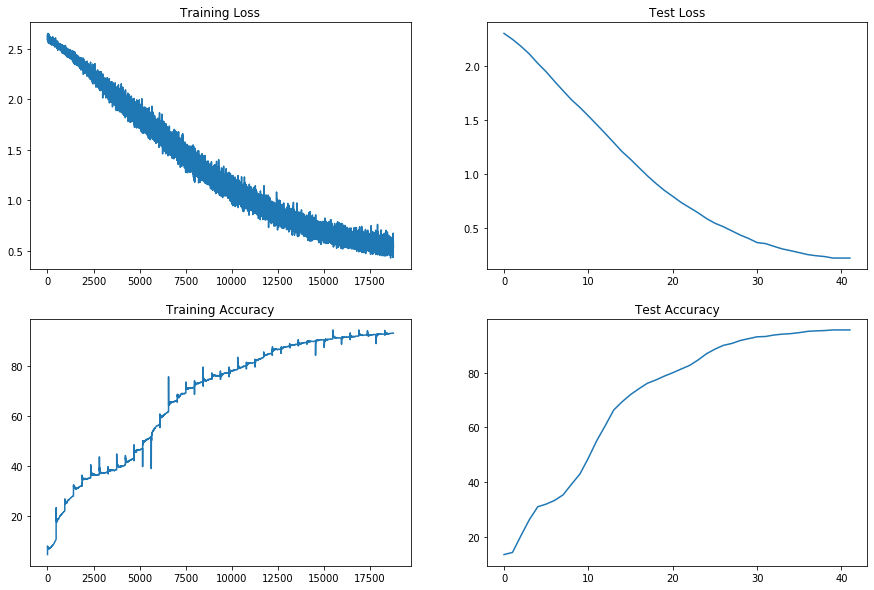

In [20]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")